In [ ]:
# Try changepoint detection algorithm instead of unit root test in step1

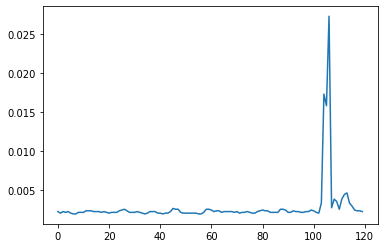

In [28]:
import sys

sys.path.append('../')
from tsdr import tsdr

import matplotlib.pyplot as plt
import numpy as np

filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user_pod-memory-hog_0.json'
data_df, _, metrics_meta = tsdr.read_metrics_json(filepath)
misdetected_series = data_df['s-user_latency'].to_numpy()
plt.plot(misdetected_series)

(<Figure size 576x288 with 1 Axes>, [<AxesSubplot:>])

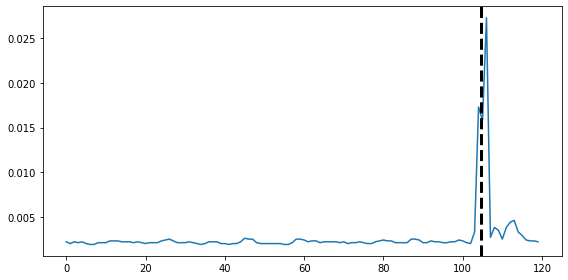

In [44]:
import ruptures as rpt

algo = rpt.Binseg(model='ar').fit(misdetected_series)
bkps = algo.predict(n_bkps=None, pen=0.0001)
rpt.show.display(misdetected_series, [], bkps, figsize=(8, 4))

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


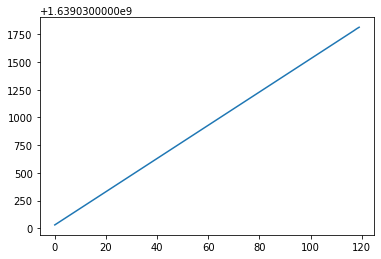

In [7]:
filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-user-db_pod-cpu-hog_0.json'
data_df, _, metrics_meta = tsdr.read_metrics_json(filepath)
liner_series = data_df['c-catalogue_last_seen'].to_numpy()
plt.plot(liner_series)

(<Figure size 576x288 with 1 Axes>, [<AxesSubplot:>])

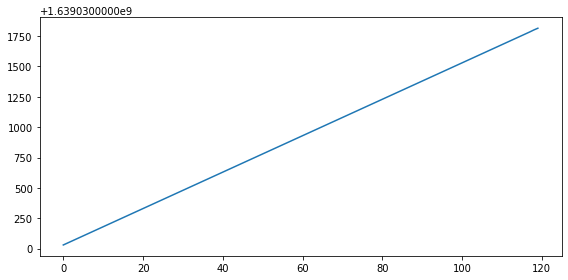

In [30]:
import ruptures as rpt

algo = rpt.Binseg(model='ar').fit(liner_series)
bkps = algo.predict(pen=10)
rpt.show.display(liner_series, [], bkps, figsize=(8, 4))

In [52]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid, breaks_hansen

_, pvalue, _ = breaks_cusumolsresid(misdetected_series)
print(f"{pvalue:.10f}")

_, pvalue, _ = breaks_cusumolsresid(liner_series)
print(f"{pvalue:.10f}")


breaks_hansen(misdetected_series)

0.0000000000
0.0000000000


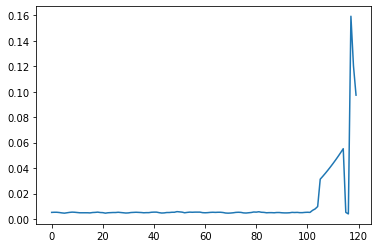

In [29]:
filepath = '/datasets/argowf-chaos-hg68n/2021-12-09-argowf-chaos-hg68n-carts_pod-memory-hog_4.json'
data_df, _, metrics_meta = tsdr.read_metrics_json(filepath)
misdetected_series2 = data_df['s-carts_latency'].to_numpy()
plt.plot(misdetected_series2)

In [25]:
import numpy as np 
import numpy.typing
import functools

class KNNOutlierDetector:
    w: int = 0
    k: int = 1

    def __init__(self, w: int, k: int) -> None:
        self.w = w        
        self.k = k
    
    def score(self, data: np.ndarray):
        windows: list[np.ndarray] = self.sliding_windows(data) 
        scores: list[float] = []
        for t in range(len(windows)):
            distances: list[float] = []
            for window in windows:
                distances.append(self.dist(windows[t], window))
            distances.sort()
            s: float = functools.reduce(lambda x, y: x+y, distances[1:self.k+1], 0.0) / self.k
            scores.append(s)
        # Adjust the size of input/output list
        return [0.0] * (self.w-1) + scores
    
    def sliding_windows(self, data: np.ndarray) -> list[np.ndarray]:
        num: int = data.size - self.w + 1
        return [data[t:t+self.w] for t in range(num)]
    
    def dist(self, v1: np.ndarray, v2: np.ndarray) -> float:
        sum: float = 0.0
        for i, v in enumerate(v1):
            sum += (v - v2[i]) * (v - v2[i])
        return np.sqrt(sum)

In [26]:
knn = KNNOutlierDetector(2, 1)
data = np.array([1, 2, 10, 2, 1])
knn.score(data)

[0.0,
 1.4142135623730951,
 8.06225774829855,
 8.06225774829855,
 1.4142135623730951]

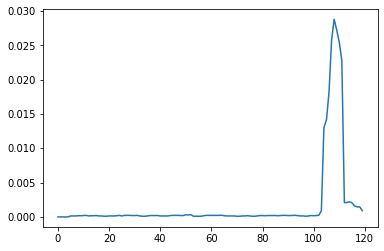

In [39]:
knn = KNNOutlierDetector(int(misdetected_series.size * 0.05), 1)
scores = knn.score(misdetected_series)
plt.plot(scores)

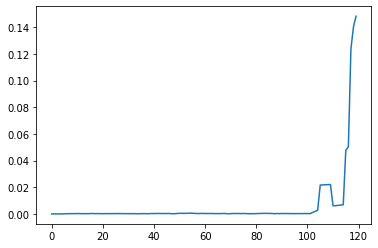

In [44]:
knn = KNNOutlierDetector(int(misdetected_series2.size * 0.05), 1)
scores2 = knn.score(misdetected_series2)
plt.plot(scores2)